<a href="https://colab.research.google.com/github/T-K-O-H/Fine_Tuning/blob/main/Fine_tuning_Embedding_Models_for_RAG_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-l`
  - Task 5: Evaluating our Retriever



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

##### ❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?

Using question and document pairs helps the model learn how to connect real questions with useful answers. This is helpful for search systems like RAG because it teaches the model to match short questions with longer texts that actually answer them. The problem is it's harder to collect lots of good quality questions, and if the questions all look the same or sound synthetic, the model won't learn well. On the other hand, using similar sentence or document pairs is easier because you're just matching texts that say similar things. But this doesn't teach the model how to answer questions, just how to recognize similar meaning. We won't train the model to understand what makes a good answer. If we are using questions to train, we need to make sure they're varied, natural, and cover different types of things people might ask. For example we training on a doc of info for FAQ for users to chat with we should feed the frequent FAQ questions and think of edge cases for such a user facing app.




## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

> NOTE: You do not need to do these steps if you are running this notebook locally with `uv`.

In [2]:
!pip install -qU "langchain_openai>=0.3.4" "langchain_huggingface" "langchain_core>=0.3.34" "langchain>=0.3.18" "langchain_community>=0.3.17" "langchain-text-splitters>=0.3.6" "datasets>=3.2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4

In [3]:
!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 16.7 MB/s eta 0:00:00


### Provide OpenAI API Key

In [4]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

Enter Your OpenAI API Key: ··········


## Task 2: Loading Data

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [5]:
!mkdir data

In [6]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31528    0 31528    0     0   300k      0 --:--:-- --:--:-- --:--:--  301k


In [7]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70695    0 70695    0     0   714k      0 --:--:-- --:--:-- --:--:--  719k


In [8]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

> NOTE: You may need to run this cell twice to get it to work.

In [10]:
training_documents = text_splitter.split_documents(text_loader.load())

In [11]:
len(training_documents)

102

Next, we're going to associate each of our chunks with a unique identifier.

In [12]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [13]:
training_split_documents = training_documents[:len(training_documents) - 24]
val_split_documents = training_documents[len(training_documents) - 24:102-12]
test_split_documents = training_documents[102-12:]

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4.1-mini`

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [14]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [15]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [16]:
question_generation_chain = qa_prompt_template | qa_chat_model

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with the `metadata` field `id`.

We need:

- An object with key `id`, which have values `str` questions.
- An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

question_object:
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

 context_object:
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [17]:
import tqdm
import asyncio

"""
Sample Usage of TQDM:

for i in tqdm.tqdm(range(10)):
  time.sleep(1)
"""

async def process_document(document, n_questions):
    questions_generated = await question_generation_chain.ainvoke({"context": document.page_content, "n_questions": n_questions})

    doc_questions = {}
    doc_relevant_docs = {}

    for question in questions_generated.content.split("\n"):
        question_id = str(uuid.uuid4())
        doc_questions[question_id] = "".join(question.split(".")[1:]).strip()
        doc_relevant_docs[question_id] = [document.metadata["id"]]

    return doc_questions, doc_relevant_docs

async def create_questions(documents, n_questions):
    tasks = [process_document(doc, n_questions) for doc in documents]

    questions = {}
    relevant_docs = {}

    for task in tqdm.tqdm(asyncio.as_completed(tasks), total=len(documents), desc="Processing documents"):
        doc_questions, doc_relevant_docs = await task
        questions.update(doc_questions)
        relevant_docs.update(doc_relevant_docs)

    return questions, relevant_docs

### REMOVE `await` IF NOT USING ASYNC (HINT: Use `async`)

In [18]:
training_questions, training_relevant_contexts = await create_questions(training_split_documents, 2)

Processing documents: 100%|██████████| 78/78 [00:05<00:00, 14.84it/s]


We'll use the function to generate training, validation, and test data.

In [19]:
val_questions, val_relevant_contexts = await create_questions(val_split_documents, 2)

Processing documents: 100%|██████████| 12/12 [00:03<00:00,  3.93it/s]


In [20]:
test_questions, test_relevant_contexts = await create_questions(test_split_documents, 2)

Processing documents: 100%|██████████| 12/12 [00:01<00:00,  6.30it/s]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [21]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [22]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [23]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-l`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-l`](https://huggingface.co/Snowflake/snowflake-arctic-embed-l) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

>> NOTE: Skip installing dependencies if you are running this notebook locally.

In [24]:
!pip install -qU sentence_transformers pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 60.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.


In [25]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [26]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [27]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [28]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [29]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [30]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

MultipleNegativesRankingLoss trains embeddings by comparing one positive pair (like a question and its correct answer) against many in-batch negatives. It pushes correct pairs closer together and incorrect ones further apart, making it ideal for retrieval tasks like semantic search. The objective is to maximize the similarity between true pairs while minimizing it for incorrect ones.

MatryoshkaLoss wraps another loss and trains the model to produce useful embeddings at multiple lengths (example: 768, 512, 256 dimensions). This makes the embeddings more flexible and efficient for different applications. This encourages the model to distribute meaningful information across all dimensions, ensuring that even truncated embeddings retain significant semantic information.



> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [31]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [32]:
EPOCHS = 10

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [33]:
import wandb
wandb.init(mode="disabled")

> NOTE: You may not see direct improvement during the training cycles - this is absolutely expected. We will verify performance later in the notebook.

In [34]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
16,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
32,No log,No log,0.875000,0.958333,1.000000,1.000000,0.875000,0.319444,0.200000,0.100000,0.875000,0.958333,1.000000,1.000000,0.945522,0.927083,0.927083
48,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.948411,0.930556,0.930556
50,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.948411,0.930556,0.930556
64,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.963789,0.951389,0.951389
80,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
96,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
100,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
112,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
128,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500


In [35]:
from huggingface_hub import notebook_login

notebook_login()

In [36]:
hf_username = "Shipmaster1"

In [37]:
import uuid

model.push_to_hub(f"{hf_username}/legal-ft-{uuid.uuid4()}")

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'https://huggingface.co/Shipmaster1/legal-ft-cbc0ac9f-1d6a-42e8-b7fe-934be9ec4f83/commit/a6215464eeeb4716722885b13f1b8f8b5bee2779'

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [38]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [39]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [40]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


In [41]:
te3_results_df = pd.DataFrame(te3_results)

In [42]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

np.float64(1.0)

### `Snowflake/snowflake-arctic-embed-l` (base)

In [43]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 24/24 [00:00<00:00, 48.08it/s]


In [44]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [45]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.8333333333333334)

### `Snowflake/snowflake-arctic-embed-l` (fine-tuned)

In [46]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic_ft")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic_ft and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 24/24 [00:00<00:00, 46.00it/s]


In [47]:
finetune_results_df = pd.DataFrame(finetune_results)

In [48]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(0.9583333333333334)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [49]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [50]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [51]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [52]:
rag_llm =  ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [53]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [54]:
base_rag_chain.invoke({"question" : "What is an agent?"})["response"]

'Based on the provided context, the term "agent" is used in various ways and lacks a clear, universally accepted definition. Some see agents as systems that can act on your behalf, like travel agents or digital assistants, while others refer to AI systems that can access tools and operate in loops to solve problems. However, the concept remains vague and often associated with hype and uncertainty, with many examples still in prototype stages rather than production. Overall, an "agent" generally refers to an AI system capable of performing tasks or making decisions on behalf of a user, but its precise meaning varies and is often unclear.'

In [55]:
base_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Organizations such as Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, and Baidu have produced models that are better than GPT-3.'

In [56]:
base_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'The provided context does not specify or mention a particular time of year that is considered the "laziest" for AI.'

In [57]:
base_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The provided context does not specify the name "Simon" or details about the largest model he has run on his phone. Therefore, I do not know the answer.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [58]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [59]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [60]:
finetune_rag_chain.invoke({"question" : "What is an Agent?"})["response"]

'Based on the provided context, an "agent" is a term that remains vague and lacks a clear, universally accepted definition. Different people interpret it in various ways: some see it as systems that act on your behalf, like travel agents or digital assistants, while others think of it as LLMs given access to tools to solve problems iteratively. The term "agent" is often associated with concepts like autonomy, but without a precise or consistent meaning. Overall, the concept of an agent is still somewhat "coming soon," and its utility is questioned due to issues like gullibility and the difficulty of distinguishing truth from fiction in AI systems.'

In [61]:
finetune_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Several organizations have produced models better than GPT-3, including Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, and Baidu.'

In [62]:
finetune_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'I do not know.'

In [63]:
finetune_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The largest model that Simon has run on his phone is Mistral 7B.'

#### ❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

1. Answer reflects factual information. It shows reasoning and understanding of our context.

2. This is a bad answer because we could have handled it better by how pre-tuning model previously handled it "The provided context does not specify a particular time of year that is considered the "laziest" for AI." or similar would been great

3. This is a great answer because it shows understanding of the content and pulls the relevant information about Simon's phone model ran. This gives us a detailed and factual answer better than before



## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [66]:
# === INSTALL IF NEEDED ===
#!pip install ragas==0.2.8 langchain langchain-core langchain-openai langchain-community datasets unstructured

# === IMPORTS ===
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.evaluation import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision
from datasets import Dataset
import pandas as pd

# === LOAD & SPLIT DOCS ===
loader = DirectoryLoader("data", glob="*.html")  # Folder with your .html files
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = splitter.split_documents(docs)[:10]  # Reduce for cost

# === EMBEDDING + VECTORSTORE ===
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.from_documents(split_docs, embedding_model)

base_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
finetuned_retriever = base_retriever  # Replace with your actual retriever if applicable

# === LLM SETUP ===
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# === MANUAL TESTSET CREATION ===
questions = [doc.page_content[:100] for doc in split_docs[:5]]
references = [""] * len(questions)
contexts = [[doc.page_content] for doc in split_docs[:5]]

testset = Dataset.from_dict({
    "question": questions,
    "reference": references,
    "contexts": contexts,
})

# === RAG PROMPT ===
rag_prompt_template = PromptTemplate.from_template("""
Use the following context to answer the question.
Context: {context}
Question: {question}
Answer:
""")

# === RAG CHAINS ===
base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | llm | StrOutputParser(), "context": itemgetter("context")}
)

finetuned_rag_chain = (
    {"context": itemgetter("question") | finetuned_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | llm | StrOutputParser(), "context": itemgetter("context")}
)

# === WRAP RAG CHAINS ===
def base_rag_fn(question):
    result = base_rag_chain.invoke({"question": question})
    return result["response"], result["context"]

def finetuned_rag_fn(question):
    result = finetuned_rag_chain.invoke({"question": question})
    return result["response"], result["context"]

# === ADD RESPONSES TO TESTSET FOR BASELINE ===
responses = []
contexts_used = []

for row in testset:
    answer, used_context = base_rag_fn(row["question"])
    responses.append(answer)
    contexts_used.append(used_context)

# Convert context docs to plain text
contexts_used_text = ["\n".join(doc.page_content for doc in ctx) for ctx in contexts_used]

testset_with_base = testset.add_column("response", responses)
testset_with_base = testset_with_base.add_column("output_contexts", contexts_used_text)

# === METRICS ===
metrics = [faithfulness, answer_relevancy, context_precision]

# === EVALUATE BASELINE ===
base_results = evaluate(testset_with_base, metrics)
df_base = base_results.to_pandas()
df_base["model"] = "base"

# === ADD RESPONSES TO TESTSET FOR FINETUNED ===
responses_ft = []
contexts_used_ft = []

for row in testset:
    answer, used_context = finetuned_rag_fn(row["question"])
    responses_ft.append(answer)
    contexts_used_ft.append(used_context)

contexts_used_ft_text = ["\n".join(doc.page_content for doc in ctx) for ctx in contexts_used_ft]

testset_with_finetuned = testset.add_column("response", responses_ft)
testset_with_finetuned = testset_with_finetuned.add_column("output_contexts", contexts_used_ft_text)

# === EVALUATE FINETUNED ===
finetuned_results = evaluate(testset_with_finetuned, metrics)
df_finetuned = finetuned_results.to_pandas()
df_finetuned["model"] = "finetuned"


df_combined = pd.concat([df_base, df_finetuned], ignore_index=True)
print(df_combined)




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

                                          user_input  \
0  Simon Willison’s Weblog\n\nSubscribe\n\nStuff ...   
1  Large Language Models\n\nThey’re actually quit...   
2  My blog in 2023\n\nHere’s the sequel to this p...   
3  They can also help you cheat at your homework,...   
4  A lot of people are yet to be sold on their va...   
5  Simon Willison’s Weblog\n\nSubscribe\n\nStuff ...   
6  Large Language Models\n\nThey’re actually quit...   
7  My blog in 2023\n\nHere’s the sequel to this p...   
8  They can also help you cheat at your homework,...   
9  A lot of people are yet to be sold on their va...   

                                  retrieved_contexts  \
0  [Simon Willison’s Weblog\n\nSubscribe\n\nStuff...   
1  [Large Language Models\n\nThey’re actually qui...   
2  [My blog in 2023\n\nHere’s the sequel to this ...   
3  [They can also help you cheat at your homework...   
4  [A lot of people are yet to be sold on their v...   
5  [Simon Willison’s Weblog\n\nSubscribe\n\nStu

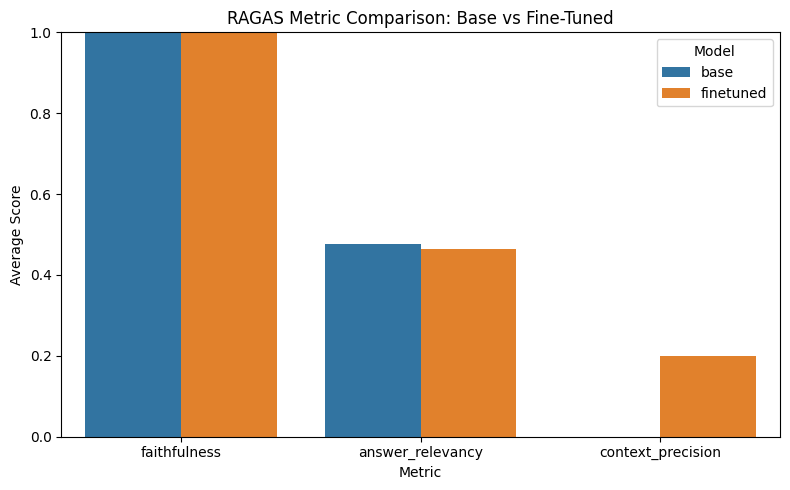

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Average metrics per model
avg_scores = df_combined.groupby("model")[["faithfulness", "answer_relevancy", "context_precision"]].mean().reset_index()

# Melt for seaborn
df_melted = avg_scores.melt(id_vars="model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="model")
plt.title("RAGAS Metric Comparison: Base vs Fine-Tuned")
plt.ylim(0, 1)
plt.ylabel("Average Score")
plt.xlabel("Metric")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[4]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[12]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[20]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[28]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[23]: ValueError(zero-size array to reduction operation maximum which has no identity)
ERROR:

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[12]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[4]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[20]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[28]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[23]: ValueError(zero-size array to reduction operation maximum which has no identity)
ERROR:

                                          user_input  \
0  Simon Willison’s Weblog\n\nSubscribe\n\nStuff ...   
1  Large Language Models\n\nThey’re actually quit...   
2  My blog in 2023\n\nHere’s the sequel to this p...   
3  They can also help you cheat at your homework,...   
4  A lot of people are yet to be sold on their va...   
5  Simon Willison’s Weblog\n\nSubscribe\n\nStuff ...   
6  Large Language Models\n\nThey’re actually quit...   
7  My blog in 2023\n\nHere’s the sequel to this p...   
8  They can also help you cheat at your homework,...   
9  A lot of people are yet to be sold on their va...   

                                  retrieved_contexts  \
0  [Simon Willison’s Weblog\n\nSubscribe\n\nStuff...   
1  [Large Language Models\n\nThey’re actually qui...   
2  [My blog in 2023\n\nHere’s the sequel to this ...   
3  [They can also help you cheat at your homework...   
4  [A lot of people are yet to be sold on their v...   
5  [Simon Willison’s Weblog\n\nSubscribe\n\nStu

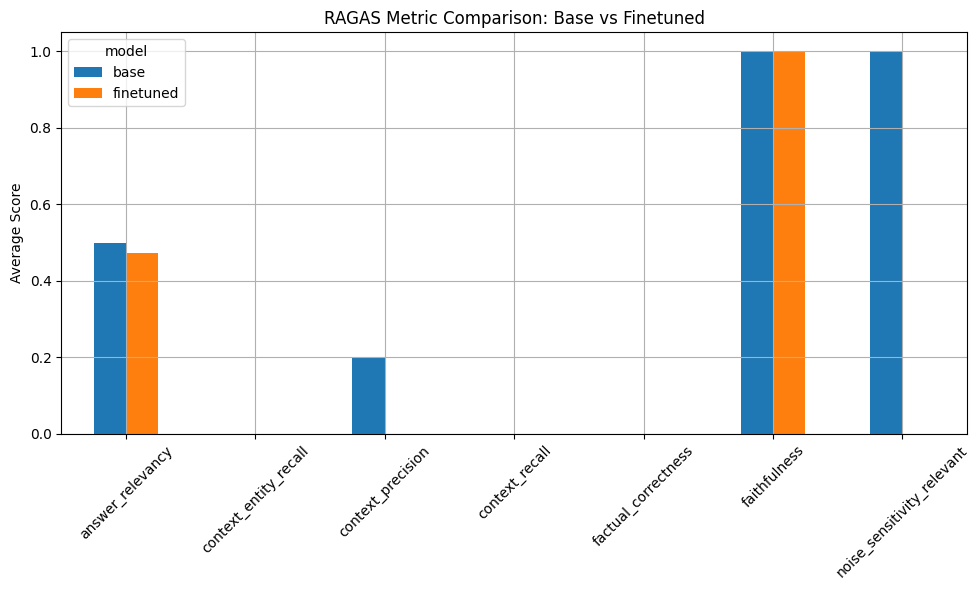

In [78]:


# === IMPORTS ===
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.evaluation import evaluate
from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    ContextPrecision,
    LLMContextRecall,
    FactualCorrectness,
    ResponseRelevancy,
    ContextEntityRecall,
    NoiseSensitivity,
)

from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt

# === LOAD & SPLIT DOCUMENTS ===
loader = DirectoryLoader("data", glob="*.html")
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = splitter.split_documents(docs)[:10]

# === EMBEDDINGS + VECTORSTORE ===
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.from_documents(split_docs, embedding_model)

base_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
finetuned_retriever = base_retriever  # Replace with actual finetuned retriever

# === LLM ===
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# === TESTSET (MANUAL) ===
questions = [doc.page_content[:100] for doc in split_docs[:5]]
references = [""] * len(questions)
contexts = [[doc.page_content] for doc in split_docs[:5]]

testset = Dataset.from_dict({
    "question": questions,
    "reference": references,
    "contexts": contexts,
})

# === PROMPT TEMPLATE ===
rag_prompt_template = PromptTemplate.from_template("""
Use the following context to answer the question.
Context: {context}
Question: {question}
Answer:
""")

# === RAG CHAINS ===
base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | llm | StrOutputParser(), "context": itemgetter("context")}
)

finetuned_rag_chain = (
    {"context": itemgetter("question") | finetuned_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | llm | StrOutputParser(), "context": itemgetter("context")}
)

# === WRAPPERS ===
def run_rag_chain(chain, question):
    result = chain.invoke({"question": question})
    return result["response"], result["context"]

# === GENERATE RESPONSES FOR BASELINE ===
base_responses, base_contexts = [], []
for row in testset:
    answer, context = run_rag_chain(base_rag_chain, row["question"])
    base_responses.append(answer)
    base_contexts.append("\n".join(doc.page_content for doc in context))

testset_with_base = testset.add_column("response", base_responses)
testset_with_base = testset_with_base.add_column("output_contexts", base_contexts)

# === GENERATE RESPONSES FOR FINETUNED ===
finetuned_responses, finetuned_contexts = [], []
for row in testset:
    answer, context = run_rag_chain(finetuned_rag_chain, row["question"])
    finetuned_responses.append(answer)
    finetuned_contexts.append("\n".join(doc.page_content for doc in context))

testset_with_finetuned = testset.add_column("response", finetuned_responses)
testset_with_finetuned = testset_with_finetuned.add_column("output_contexts", finetuned_contexts)

# === METRICS ===
metrics = [
    Faithfulness(),
    AnswerRelevancy(),
    ContextPrecision(),
    LLMContextRecall(),
    FactualCorrectness(),
    ResponseRelevancy(),
    ContextEntityRecall(),
    NoiseSensitivity(),
]

# === EVALUATE ===
base_results = evaluate(testset_with_base, metrics)
finetuned_results = evaluate(testset_with_finetuned, metrics)

df_base = base_results.to_pandas()
df_base["model"] = "base"
df_finetuned = finetuned_results.to_pandas()
df_finetuned["model"] = "finetuned"

df_combined = pd.concat([df_base, df_finetuned], ignore_index=True)
print(df_combined)

# === PLOT ===
metrics_to_plot = df_combined.columns.difference(["user_input", "retrieved_contexts", "response", "reference", "model"])
avg_scores = df_combined.groupby("model")[metrics_to_plot].mean().T

avg_scores.plot(kind="bar", figsize=(10, 6))
plt.title("RAGAS Metric Comparison: Base vs Finetuned")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()